# Transform image of array to digital values 


This notebook provides:
        - search for spots on array
        - mapping images postions peptides to peptides informations
        - extracting intensities of spots and mapping to coresponding spots
        - writing gal-file for further analysis with analysis script 
        


In [13]:
import numpy as np
import pandas as pd
import math
import cv2
import argparse
import imutils
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.image as mpimg

from sklearn import decomposition
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors



from skimage import data, io, filters,measure
from skimage.feature import match_template 

import scipy
from scipy.ndimage.interpolation import shift
from scipy import ndimage,spatial
from scipy.optimize import leastsq, minimize
import scipy.ndimage.filters as filters



from IPython.display import display, HTML
from PIL import Image
import PIL.ImageOps 
from imutils import contours



## define help functions

In [14]:
def draw_imag(im,name, **kwargs):
    fig, ax = plt.subplots(figsize=(30,10))
    plt.title(name)
    plt.imshow(im, **kwargs)
    plt.colorbar()
    plt.show()


def draw_circles(img, circles, **kwargs):
    """
    draws a circles in an image (img)
    """
    fig, ax = plt.subplots(figsize=(30, 10))
    plt.imshow(img.T, **kwargs)
    plt.colorbar()
    plt.scatter(circles[0, :, 1], circles[0, :, 0], s=circles[0, :, 2], color="r")
    plt.show()


def draw_grid(img, X, Y, name, **kwargs):
    """
    draws a circles in an image (img)
    """

    fig, ax = plt.subplots(figsize=(30, 10))
    plt.imshow(img, **kwargs)
    plt.colorbar()
    plt.title(name)
    plt.scatter(X, Y, alpha=0.5, color="r")
    plt.show()

def get_contour(gray):
    """
    finds contours in image
    """
    ret, thresh = cv2.threshold( gray, 60, 255, 1)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return im2,contours





    

## Load data
    -Load galfile of peptides
    -Load images after spotting but before incubation with virus
    -Load images after incubation with virus

In [15]:
data_ids = {'N10'}
#--------------------------
#data_id = 'E5'
data_id = 'N10'
#--------------------------
if any(data_id == d_id for d_id in ['N10', 'E5' ]):
    #load raw data
    
    #pep= pd.read_csv("data/{}_pep.gal".format(data_id), sep='\t',index_col="ID")
    for fname in os.listdir('data/'):    # change directory as needed
        if os.path.isfile('data/{}'.format(fname)):# make sure it's a file, not a directory entry
            #print(fname)
            if "{}_600_100_635.tif".format(data_id) in fname:    # search for string
                print(fname)
                im =  cv2.imread("data/{}".format(fname), 0)
            elif "{}_after_600_100_635.tif".format(data_id) in fname:    # search for string
                print(fname)
                imafter =  cv2.imread("data/{}".format(fname), 0)
            elif "{}_pep.gal".format(data_id) in fname:
                print(fname)
                pep = pd.read_csv("data/{}".format(fname), sep='\t',index_col="ID")
                pep_cor = pep.pivot(index="Row", columns="Column", values="Name")    
# unstack peptide coordinates data
pep_cor_unstacked=pep_cor.unstack()
# only fluorecent data
leuchtefix=pep_cor_unstacked.str.contains("Leuchte")


    


N10_600_100_635.tif
N10_pep.gal
N10_after_600_100_635.tif


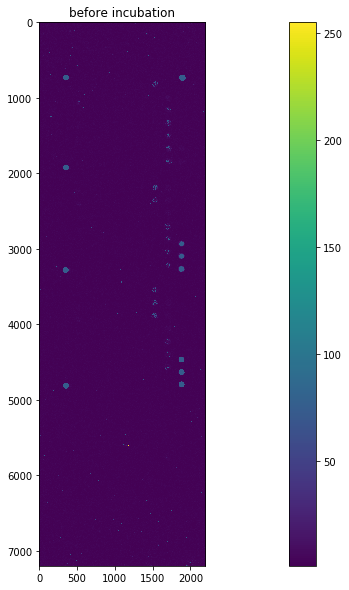

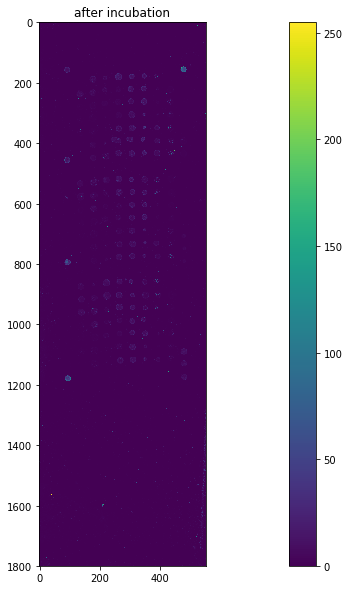

In [16]:
draw_imag(im,"before incubation")
draw_imag(imafter,"after incubation")

# Define functions for Spot detection:

In [17]:
def detect_circles(image):
    """
    detects circles from images
    """
    draw_imag(-image.T,"Inverted Orignal Picture")
    
    gray_blur = cv2.medianBlur(image, 29)  # Remove noise before laplacian
    draw_imag(-gray_blur.T,"Inverted Blured Picture")
    
    
    gray_contr,contours=get_contour(gray_blur)
    draw_imag(-gray_contr.T,"Inverted conture Picture")
    
    gray_lap = cv2.Laplacian(gray_contr, cv2.CV_8UC1, ksize=5)    
    draw_imag(-gray_lap.T,"Inverted Laplacian Picture")

    
    dilate_lap = cv2.dilate(gray_lap, (3, 3)) 
    draw_imag(-dilate_lap.T,"Inverted  dilate Picture")
    
    
    # Fill in gaps from blurring. This helps to detect circles with broken edges.
    # Furture remove noise introduced by laplacian. This removes false pos in space between the two groups of circles.
    
    
    lap_blur = cv2.bilateralFilter(dilate_lap, 5, 9, 9)        
    draw_imag(-lap_blur.T,"Inverted after bilateral filter")

    
    circles = cv2.HoughCircles(lap_blur, cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=100)    #cimg = draw_circles(gray, circles)    #cimg = draw_circles(image_path, circles)
    print("{} circles detected.".format(circles[0].shape[0]))
    return circles
    
    
    

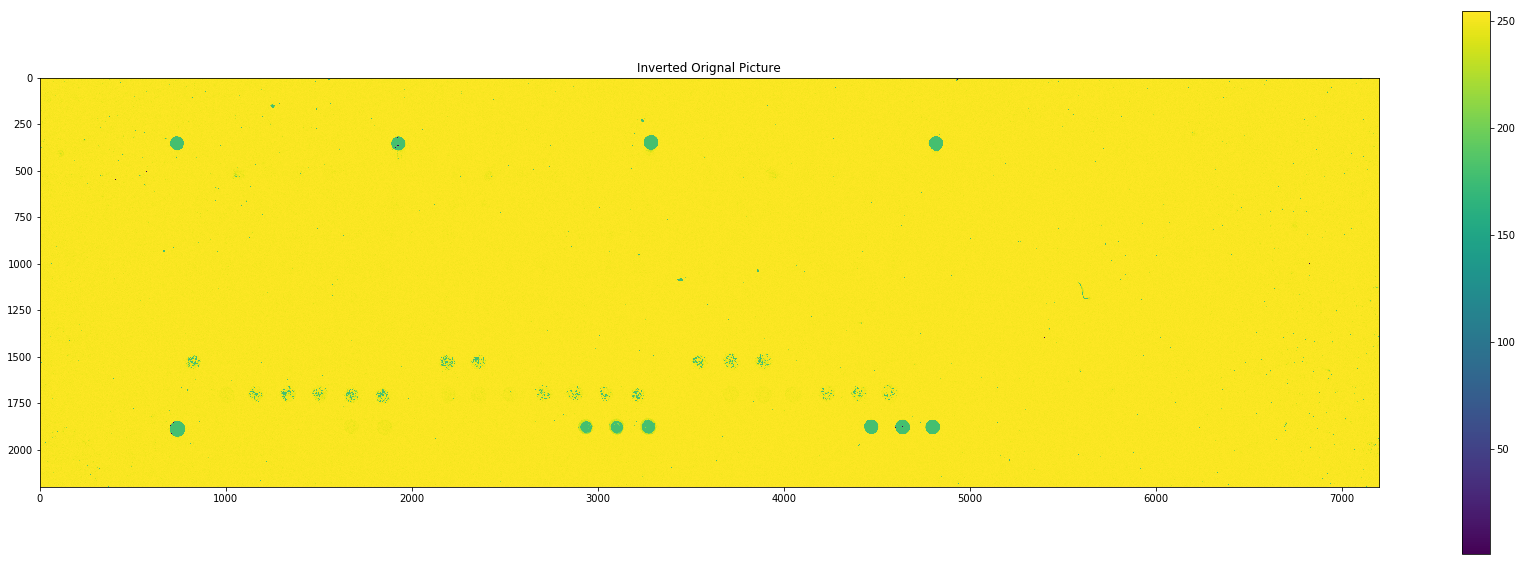

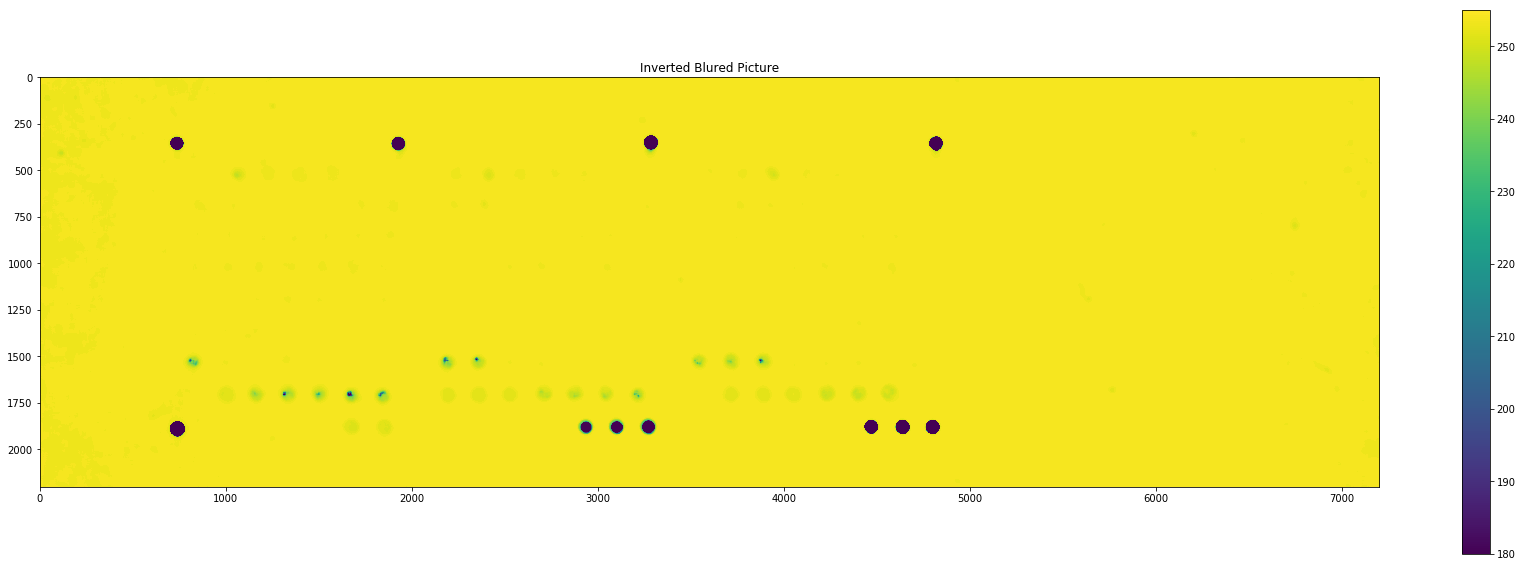

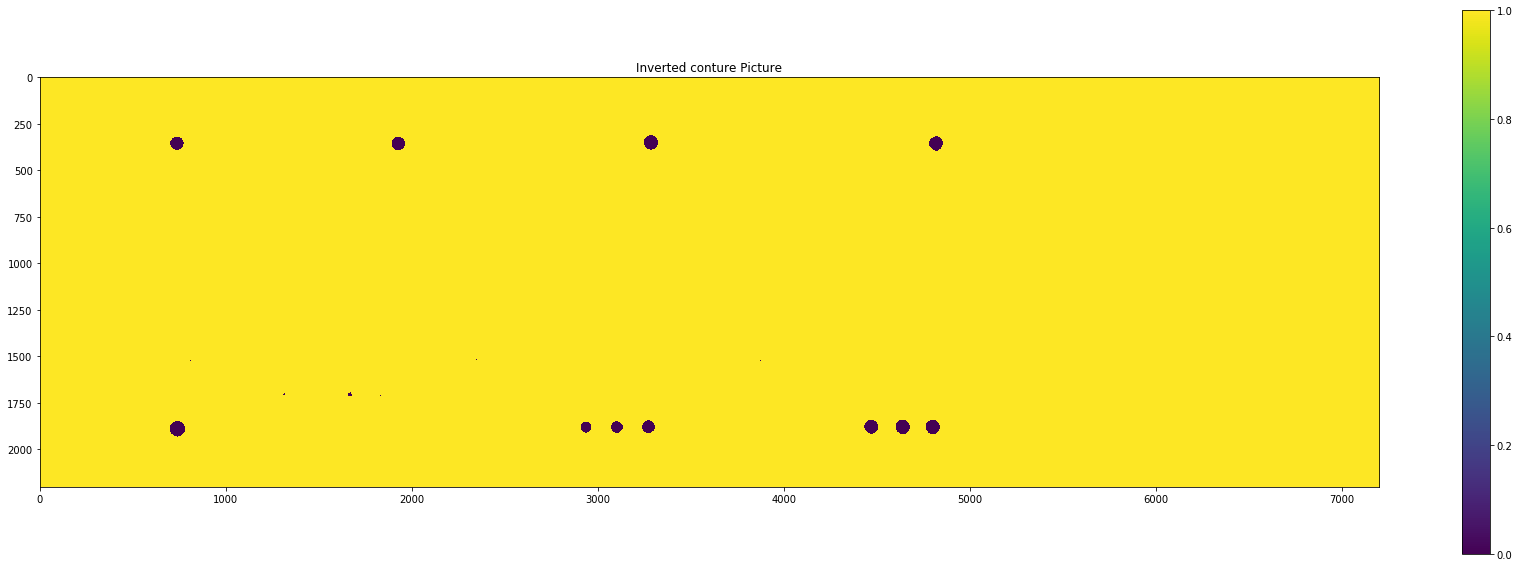

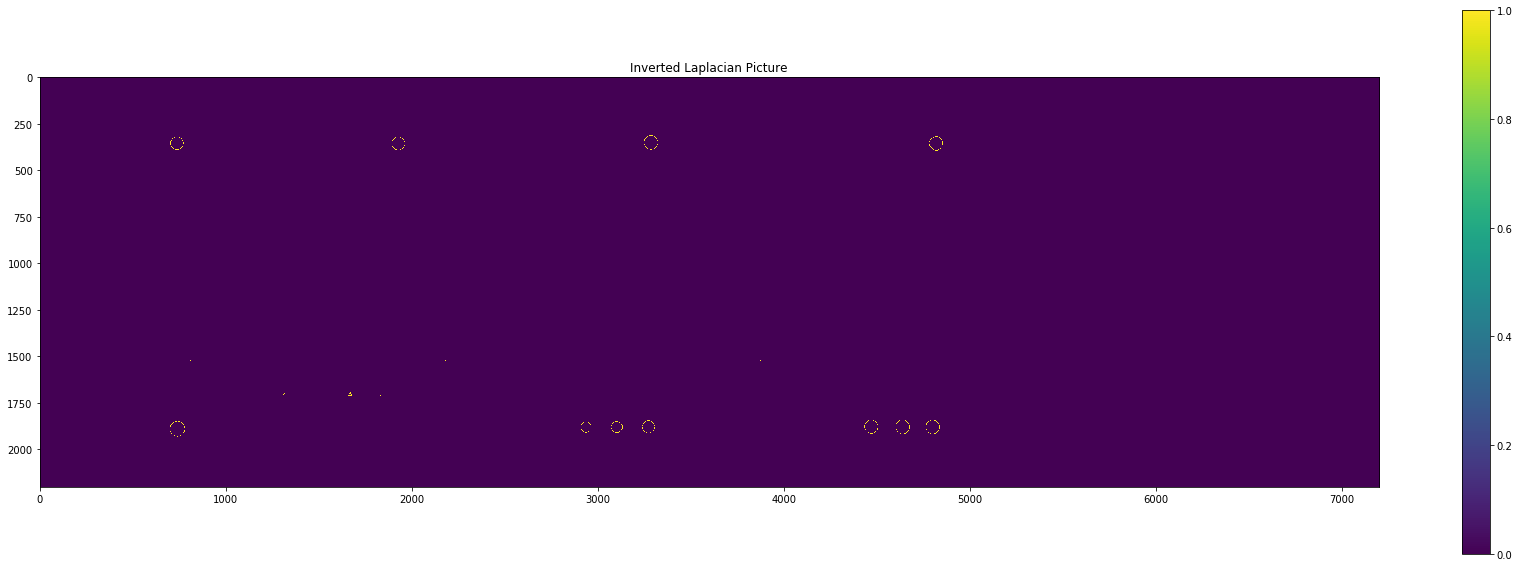

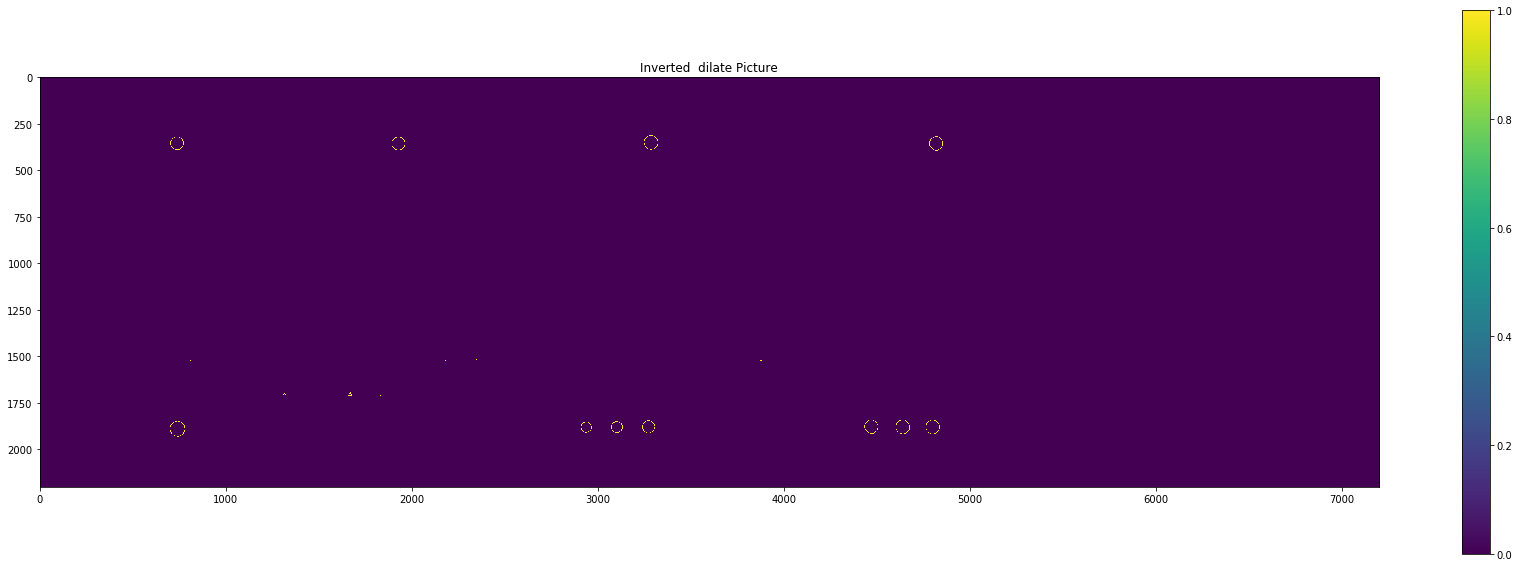

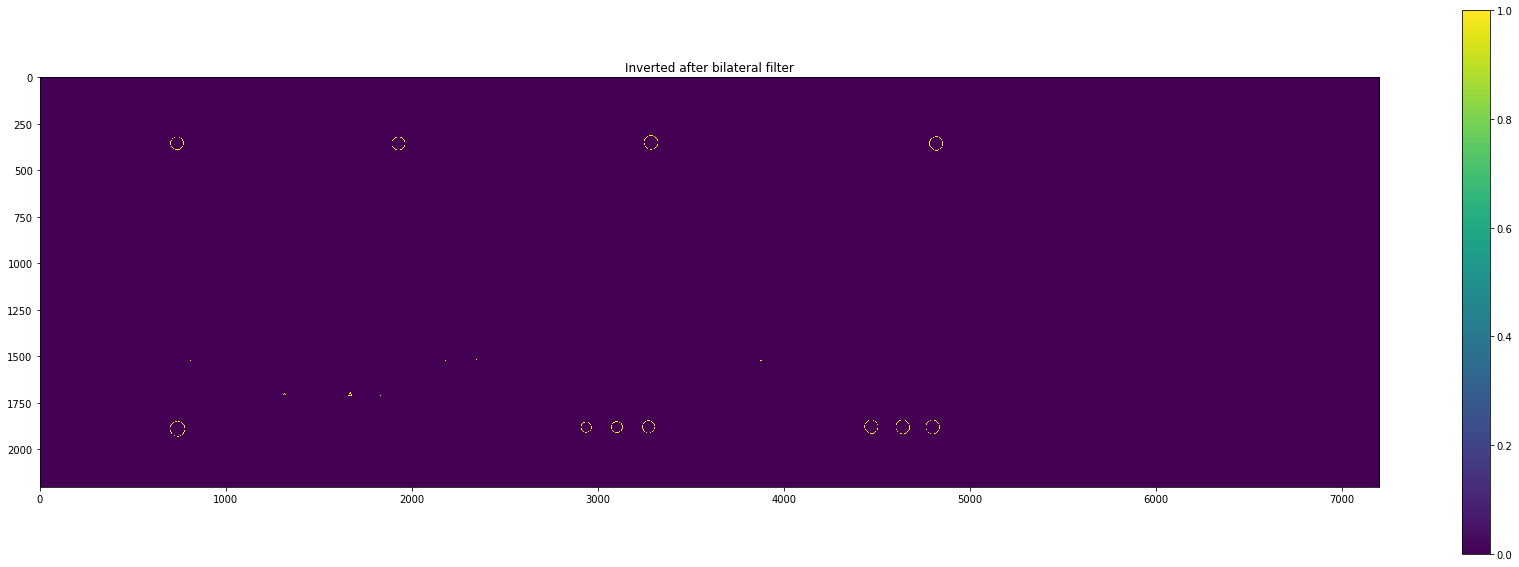

11 circles detected.


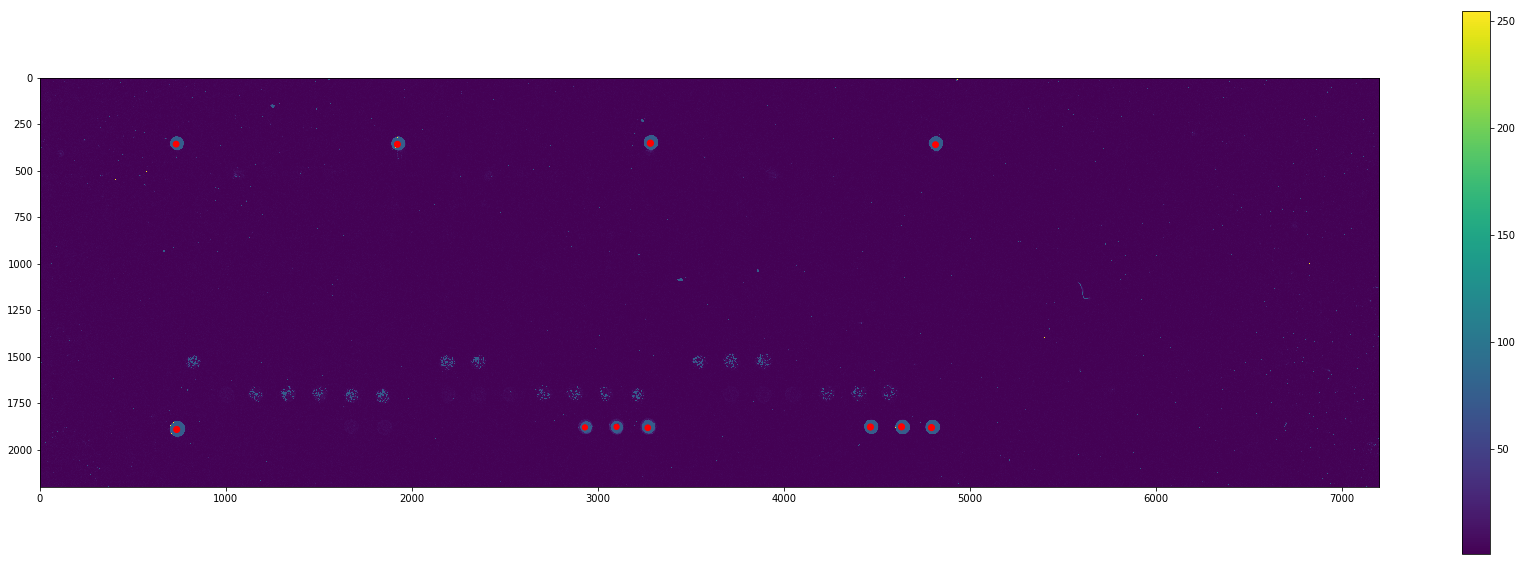

In [18]:
circles=detect_circles(im)
draw_circles(im,circles)

## Maps spot positions in image to peptide in gal file



In [19]:
# create a new Dataframe with x and y coordinates of peptides
Peptides=pd.DataFrame(pep_cor_unstacked.values,columns=["Peptides"])
Peptides["Column"]=leuchtefix.index.get_level_values(0).values
Peptides["Row"]=leuchtefix.index.get_level_values(1).values
Peptides["x"]=0
Peptides["y"]=0

display(Peptides.head())

# generate a new data frame with x and y coordinates of spots detected by previous algorithm
spot_position = pd.DataFrame(circles[0,:,0:2], columns=["x","y"])
display(spot_position)

# display all spots containing Leuchtefix
nonzero_ids=leuchtefix.nonzero() # ids of spots in gal file containing Leuchtefix
display(Peptides.iloc[nonzero_ids])

Peptides  Column  Row  x  y
0  Leuchtefix 1.0       1    1  0  0
1           blank       1    2  0  0
2           blank       1    3  0  0
3           blank       1    4  0  0
4           blank       1    5  0  0

x       y
0   1878.5  2931.5
1    356.5  1923.5
2   1880.5  3269.5
3    350.5  3283.5
4   1889.5   736.5
5   1875.5  4633.5
6   1879.5  4794.5
7    355.5   733.5
8   1875.5  3101.5
9   1876.5  4466.5
10   358.5  4816.5

Peptides  Column  Row  x  y
0     Leuchtefix 1.0       1    1  0  0
7     Leuchtefix 1.0       1    8  0  0
15    Leuchtefix 1.0       1   16  0  0
24    Leuchtefix 1.0       1   25  0  0
225   Leuchtefix 1.0      10    1  0  0
238  Leuchtefix 0.25      10   14  0  0
239  Leuchtefix 0.25      10   15  0  0
240  Leuchtefix 0.25      10   16  0  0
247   Leuchtefix 0.5      10   23  0  0
248   Leuchtefix 0.5      10   24  0  0
249   Leuchtefix 0.5      10   25  0  0

### find grid on image & map leuchtefix position on image to galfile 


In [20]:
def inverte(imagem):
    imagem = (255-imagem)
    return(imagem)


def get_grid(shape, pitch, center_x, center_y, rotation=0):
    """
    returns x,y coordinates of a grid with shape, pitch, center x , center y, rotation
    """
    x_spots, y_spots = np.meshgrid(
             (np.arange(shape[1]) - (shape[1]-1)/2.)*pitch, 
             (np.arange(shape[0]) - (shape[0]-1)/2.)*pitch, indexing='ij')
    theta = rotation/180.*np.pi
    x_spots = x_spots*np.cos(theta) - y_spots*np.sin(theta) + center_x
    y_spots = x_spots*np.sin(theta) + y_spots*np.cos(theta) + center_y
    return x_spots, y_spots

def get_nearest_on_grid(x_grid,y_grid,xe, ye, max = float('inf')):
    """
    returns x and y coordinates and index of the nearest spot on grid to a points with (xe,ye) coordinates. xe,ye can be an array of points. 
    """
    
    xy_grid=np.vstack([x_grid,y_grid]).reshape(2,-1).T
    xy_circles=np.vstack([xe, ye]).reshape(2,-1).T
    index_nearest=nearest_neighbour(xy_circles,xy_grid)
    
    #dist = np.linalg.norm(np.array([xy_grid[index_nearest,0]-xe,xy_grid[index_nearest,1]-ye]))
   
    return xy_grid[index_nearest,0],xy_grid[index_nearest,1],index_nearest
        

def nearest_neighbour(points_a, points_b):
    """
    returns coordinates of closest point in array (points a) to every point in array (points b)
    """
    tree = spatial.cKDTree(points_b)
    return tree.query(points_a)[1]


def get_mean_distance(x1, y1, x2, y2):
    """
    mean dinstance bestween (x1,y1) and (x2,y2)
    """
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2).mean()


def err_func(params, xe, ye,gridshape):
    """
    params: Grid parameters 

    returns the mean distance between leuchtefix spots in images and on grid. 
    
    """
    pitch, center_x, center_y, rotation = params
    x_grid, y_grid = get_grid(gridshape, pitch, center_x, center_y, rotation)
    x_spots, y_spots, _ = get_nearest_on_grid(x_grid, y_grid, xe, ye)
    return get_mean_distance(x_spots, y_spots, xe, ye)


def err_func2(params,pitch, xe, ye,index_grid,gridshape):
    """
    params: Grid parameters 

    returns the mean distance between leuchtefix spots in images and on grid. 
    
    """
    center_x, center_y, rotation = params
    x_grid, y_grid = get_grid(gridshape, pitch, center_x, center_y, rotation)
    pts=np.vstack([x_grid, y_grid]).reshape(2,-1).T
    return get_mean_distance(pts[findex_grid,0],pts[index_grid,1], xe, ye)


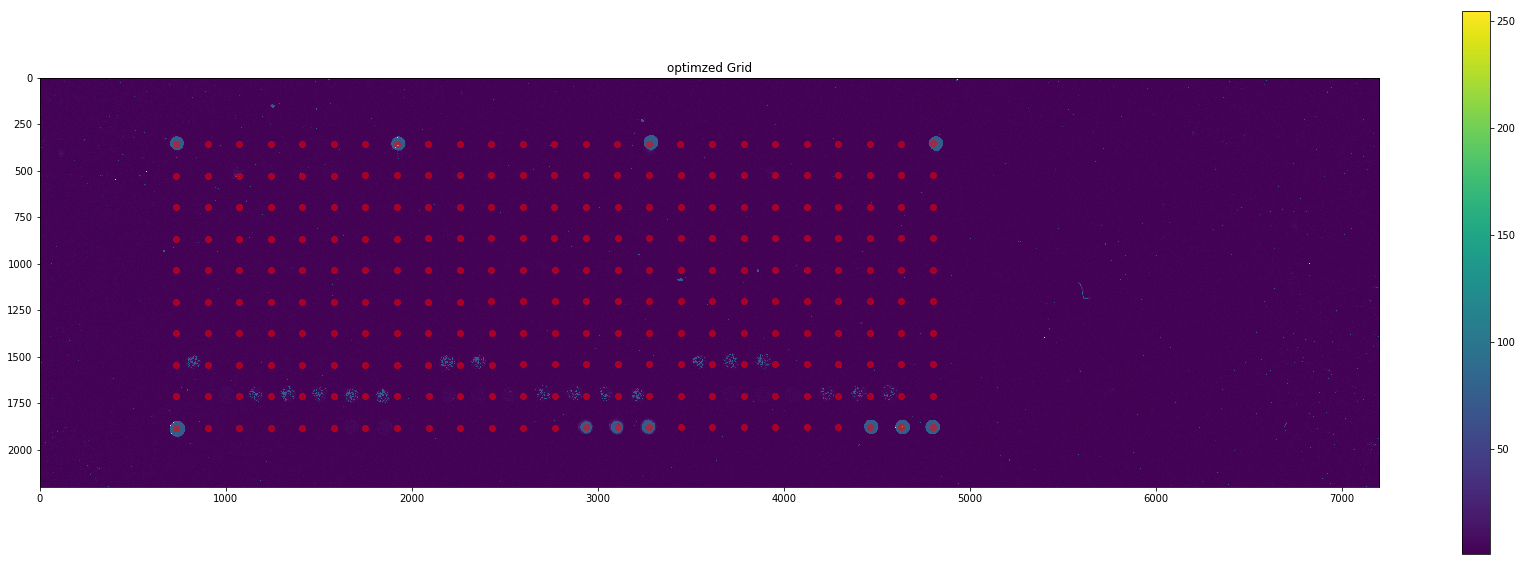

In [21]:

# estimated pitch on image
pitch=(spot_position["x"].max()-spot_position["x"].min())/(Peptides["Column"].iloc[nonzero_ids].max()-Peptides["Column"].iloc[nonzero_ids].min())
#estimated center x on image
center_x=spot_position["x"].min()+0.5*(spot_position["x"].max()-spot_position["x"].min())
#estimated center y on image 
center_y=spot_position["y"].min()+0.5*(spot_position["y"].max()-spot_position["y"].min())
#gridshape
gridshape=(Peptides["Row"].max(),Peptides["Column"].max())





#optimzes grid parameters by minimizing error function:
best_arg=minimize(err_func, x0=(pitch, center_x, center_y, 0), args=(spot_position["x"].values,spot_position["y"].values,gridshape))
X,Y=get_grid(gridshape,pitch=best_arg.x[0],center_x=best_arg.x[1],center_y=best_arg.x[2],rotation=best_arg.x[3])

#draw the grid on image
draw_grid(im.T,Y,X,"optimzed Grid")


## Map leuchtefix positions to gal file

/home/janekg89/Envs/flutype-analysis/local/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Peptides  Column  Row       x       y
0     Leuchtefix 1.0       1    1   355.5   733.5
7     Leuchtefix 1.0       1    8   356.5  1923.5
15    Leuchtefix 1.0       1   16   350.5  3283.5
24    Leuchtefix 1.0       1   25   358.5  4816.5
225   Leuchtefix 1.0      10    1  1889.5   736.5
238  Leuchtefix 0.25      10   14  1878.5  2931.5
239  Leuchtefix 0.25      10   15  1875.5  3101.5
240  Leuchtefix 0.25      10   16  1880.5  3269.5
247   Leuchtefix 0.5      10   23  1876.5  4466.5
248   Leuchtefix 0.5      10   24  1875.5  4633.5
249   Leuchtefix 0.5      10   25  1879.5  4794.5

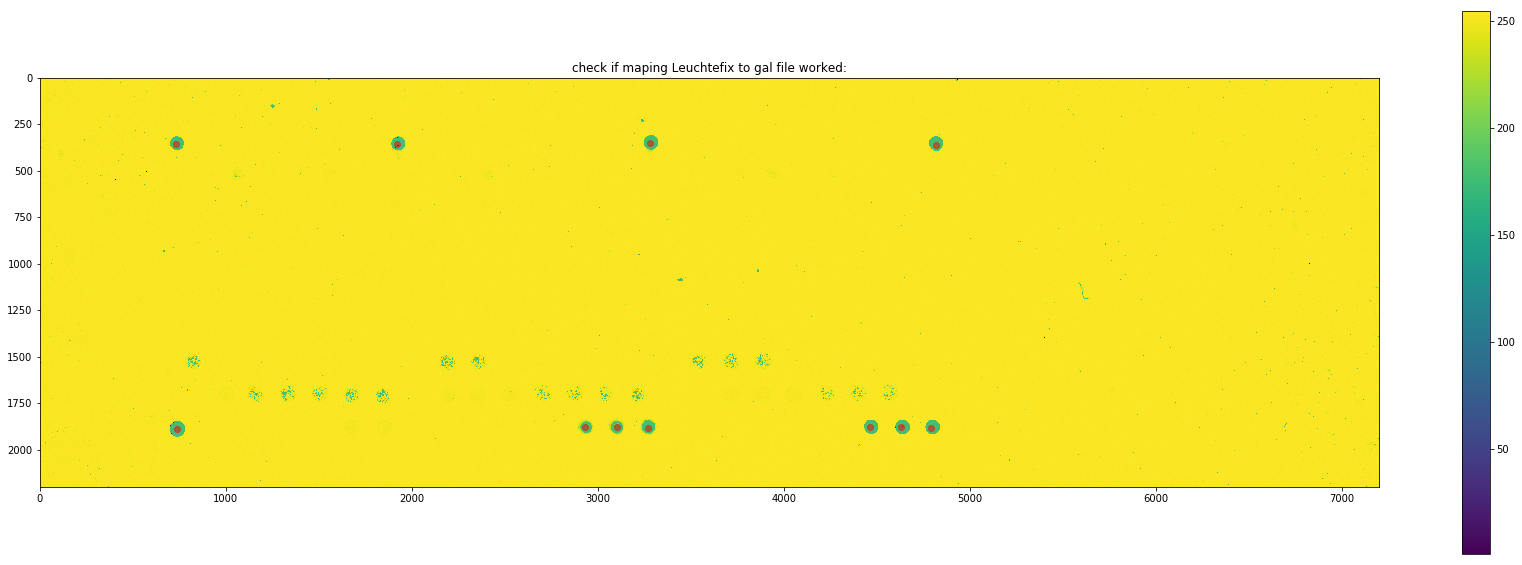

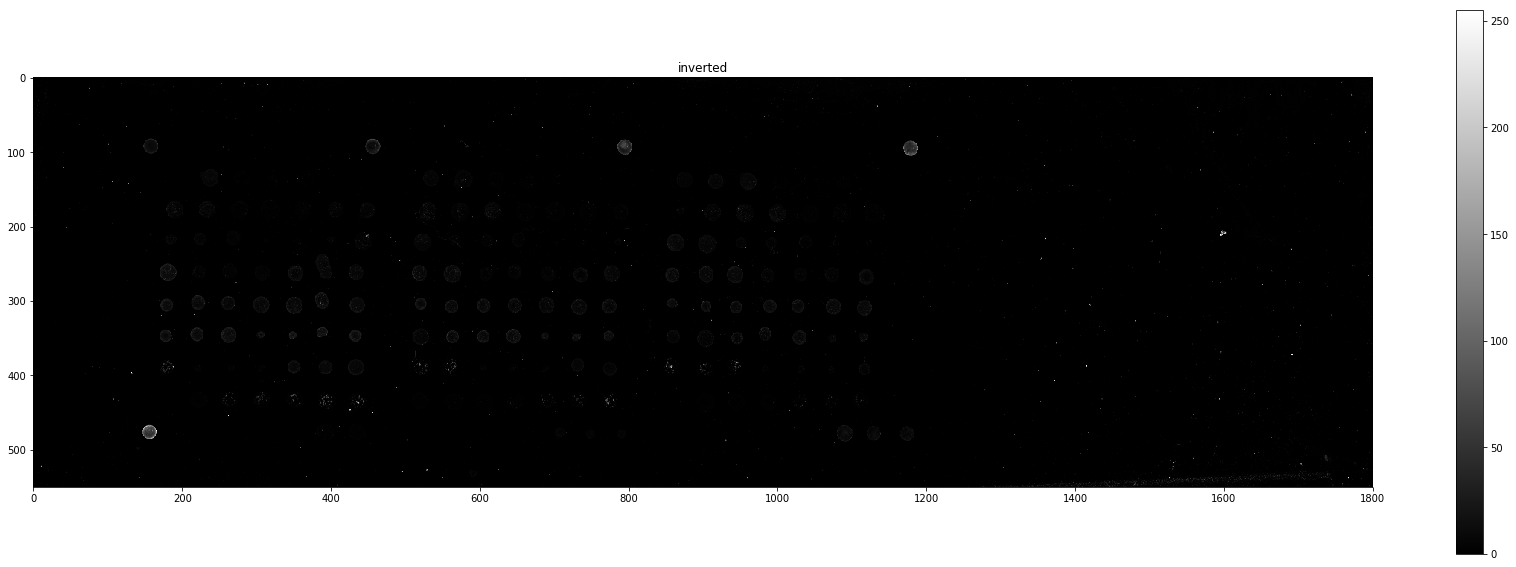

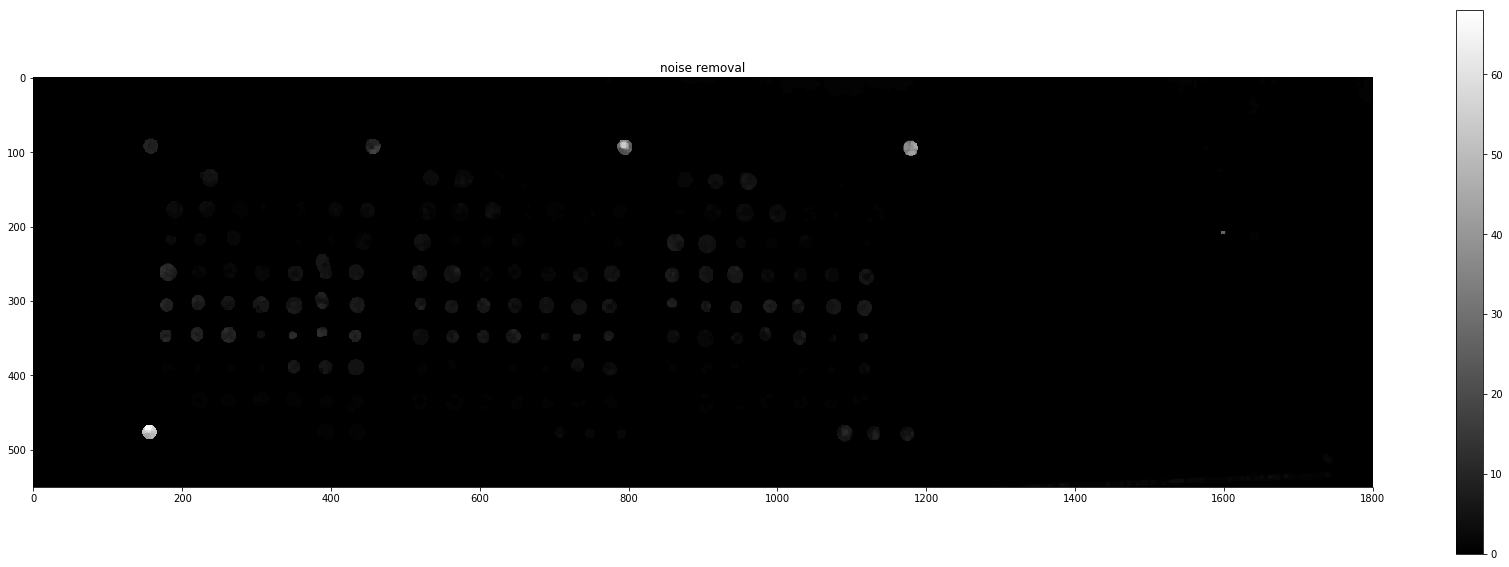

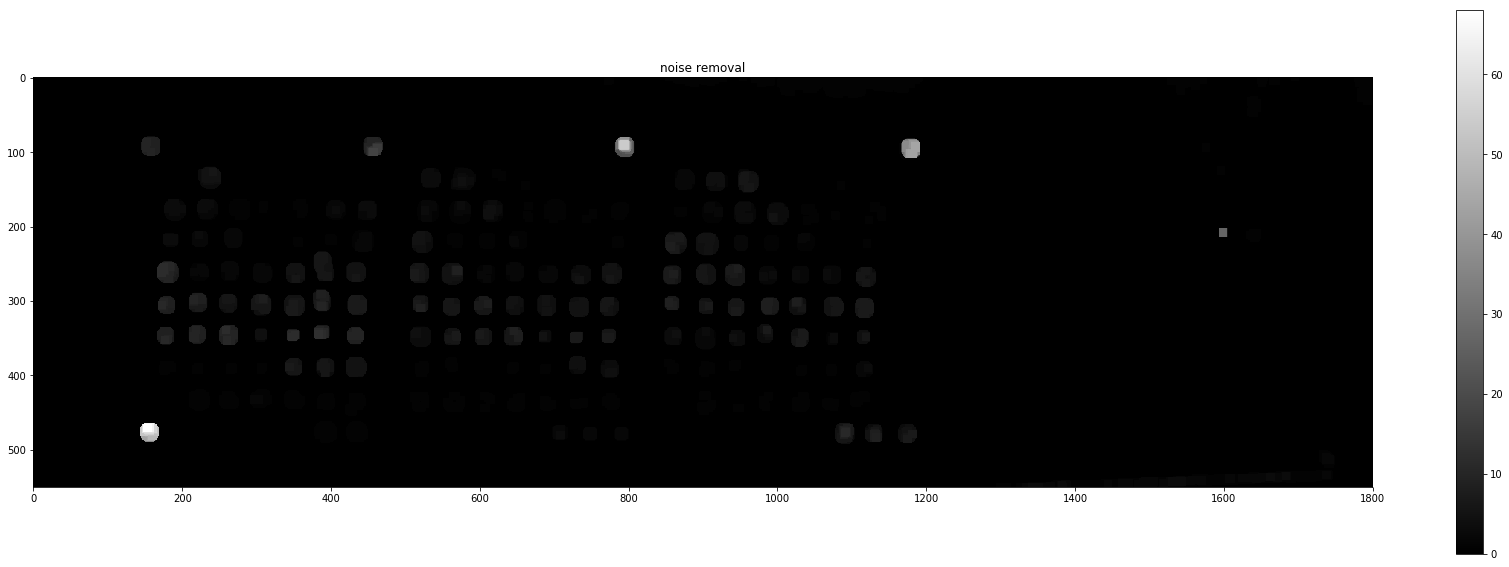

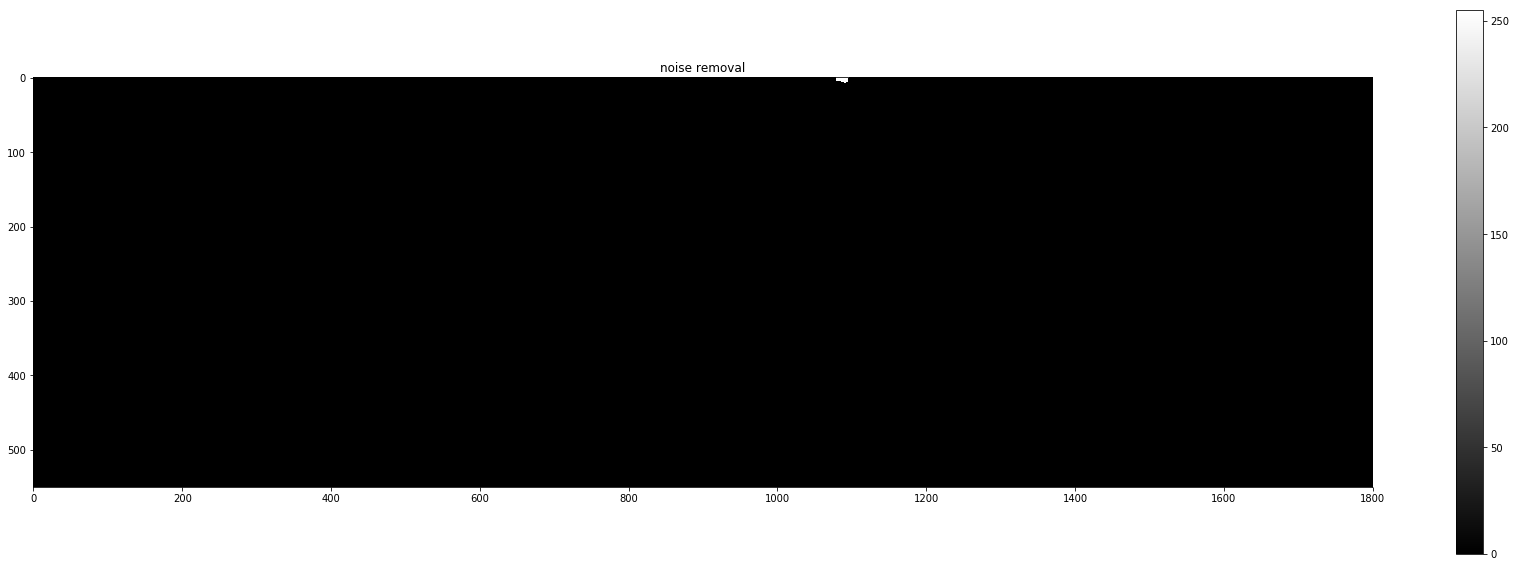

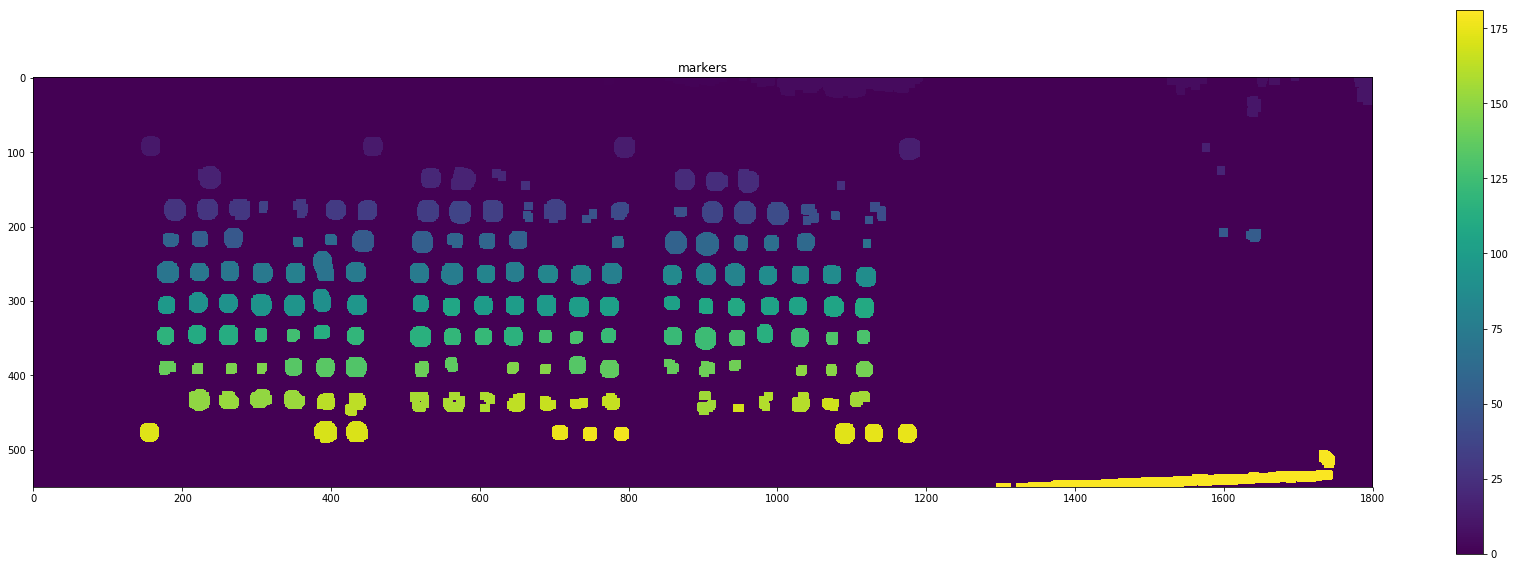

In [22]:
_, _ , leuchtefix_indexes_on_grid=get_nearest_on_grid(X,Y,spot_position["x"].values,spot_position["y"].values)

for index,grid_index in enumerate(leuchtefix_indexes_on_grid):
    Peptides['x'].iloc[grid_index]=spot_position["x"][index]
    Peptides['y'].iloc[grid_index]=spot_position["y"][index]
    
display(Peptides.iloc[nonzero_ids])  
draw_grid(-im.T,Peptides["y"].iloc[nonzero_ids],Peptides["x"].iloc[nonzero_ids],"check if maping Leuchtefix to gal file worked:")



#draw_imag(inverte(imafter.T),"inverted image", cmap="gray")

gray = imafter.T

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(gray,cv2.MORPH_OPEN,kernel, iterations = 2)

draw_imag(gray,"inverted",cmap="gray")
draw_imag(opening,"noise removal",cmap="gray")
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
draw_imag(sure_bg,"noise removal",cmap="gray")
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
draw_imag(sure_fg,"noise removal",cmap="gray")
#unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_bg)

# Add one to all labels so that sure background is not 0, but 1
draw_imag(markers,"markers")


(4, 4)


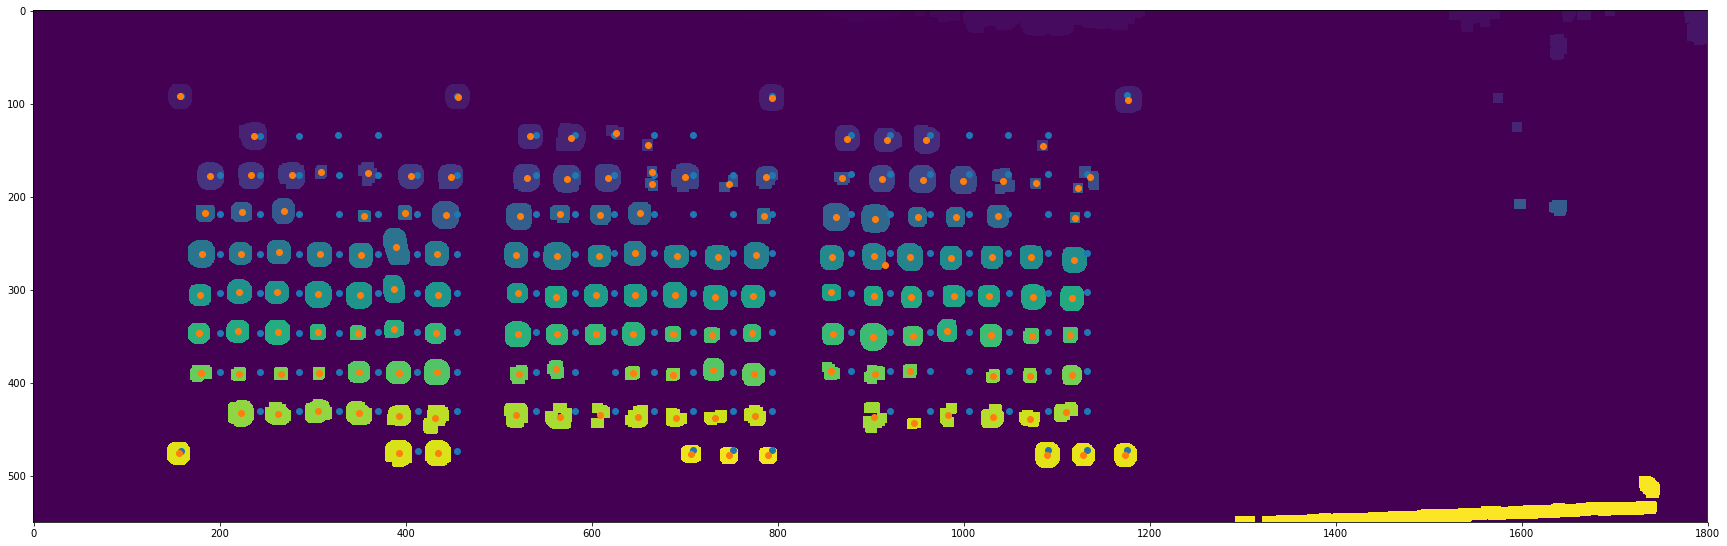

In [23]:
# show ratio of shape of images:
ratio = (im.shape[0]/imafter.shape[0],im.shape[1]/imafter.shape[1])
print(ratio)

points_x = []
points_y = []
for marker in range(markers.max()):
    point= np.array(np.where(markers == marker))
    points_x.append(point[0].mean())
    points_y.append(point[1].mean())

    
#draw_grid(imafter.T,points_y,points_x,"scatter")



xy_grid=np.vstack([X/ratio[0]+3,Y/ratio[0]-25]).reshape(2,-1).T
Peptides['x'] = xy_grid[:,0]
Peptides['y'] = xy_grid[:,1]
blank=pep_cor_unstacked.str.contains("blank")
blank_ids=blank.nonzero()
Peptides['x'].iloc[blank_ids] = float('nan')
Peptides['y'].iloc[blank_ids] = float('nan')



    
new_points =[]
pts=np.vstack([points_x,points_y]).reshape(2,-1).T
T = spatial.KDTree(xy_grid)
idx = T.query_ball_point(pts,r=50)
points_new= []
#print(len(idx))
#print(len(pts))
for index,i in enumerate(idx):
    if len(i) > 0:
        points_new.append(pts[index])
points_new = np.array(points_new)
#print(len(points_new))
#print(Peptides['x'].value_counts(dropna=False))
fig, ax = plt.subplots(figsize=(30,10))
plt.scatter(Peptides['y'],Peptides['x'])
plt.scatter(points_new[:,1],points_new[:,0])
plt.imshow(markers)
plt.show()




164
164


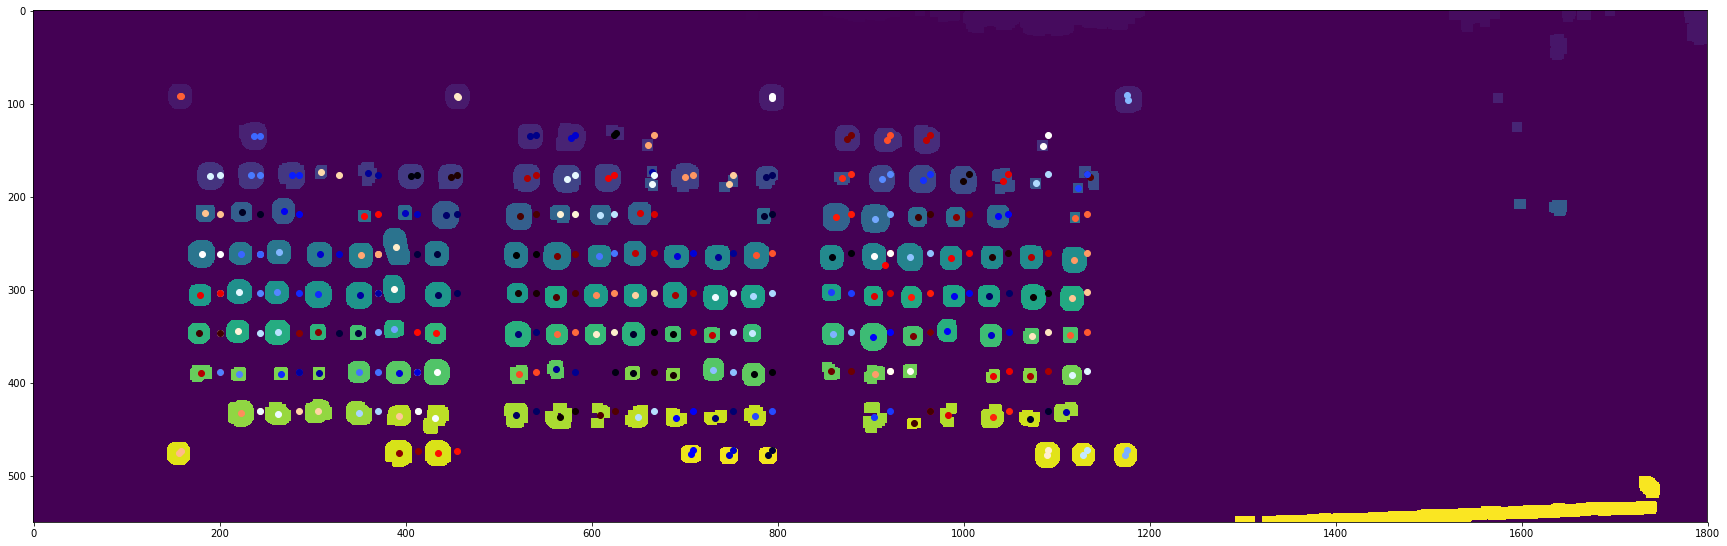

In [24]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

finite = np.isfinite(Peptides['x'])
pts=np.vstack([Peptides[finite]['x'],Peptides[finite]['y']]).reshape(2,-1).T
print(len(points_new))
nearest = nearest_neighbour(points_new, pts)
print(len(nearest))


jet = cm = plt.get_cmap('flag') 
cNorm  = colors.Normalize(vmin=0, vmax=len(nearest))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)



fig, ax = plt.subplots(figsize=(30,10))
for i_points_new,i in enumerate(nearest):
    colorVal = scalarMap.to_rgba(i_points_new)
    plt.scatter(pts[i,1],pts[i,0],color=colorVal)
    plt.scatter(points_new[i_points_new,1],points_new[i_points_new,0], color=colorVal)
plt.imshow(markers)


plt.show()



In [25]:
def estimate_grid(points,Peptides):
    # estimated pitch on image
    pitch=(points[:,0].max()-points[:,0].min())/(Peptides["Column"].iloc[nonzero_ids].max()-Peptides["Column"].iloc[nonzero_ids].min())
    #estimated center x on image
    center_x=points[:,0].min()+0.5*(points[:,0].max()-points[:,0].min())
    #estimated center y on image 
    center_y=points[:,1].min()+0.5*(points[:,1].max()-points[:,1].min())
    #gridshape
    gridshape=(Peptides["Row"].max(),Peptides["Column"].max())
    return pitch, center_x, center_y, gridshape

(array([  0,   7,  15,  24,  27,  28,  29,  30,  34,  35,  36,  37,  38,
        42,  43,  44,  45,  46,  47,  51,  52,  53,  54,  55,  56,  57,
        59,  60,  61,  62,  63,  64,  65,  67,  68,  69,  70,  71,  72,
        73,  76,  77,  78,  79,  80,  81,  82,  84,  85,  86,  87,  88,
        89,  90,  92,  93,  94,  95,  96,  97,  98, 101, 102, 103, 104,
       105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119,
       120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 132, 134, 135,
       136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 151,
       152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165,
       167, 168, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181,
       182, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196,
       197, 198, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213,
       214, 215, 218, 219, 220, 221, 222, 223, 225, 231, 232, 238, 239,
       240, 247, 248, 249]),)


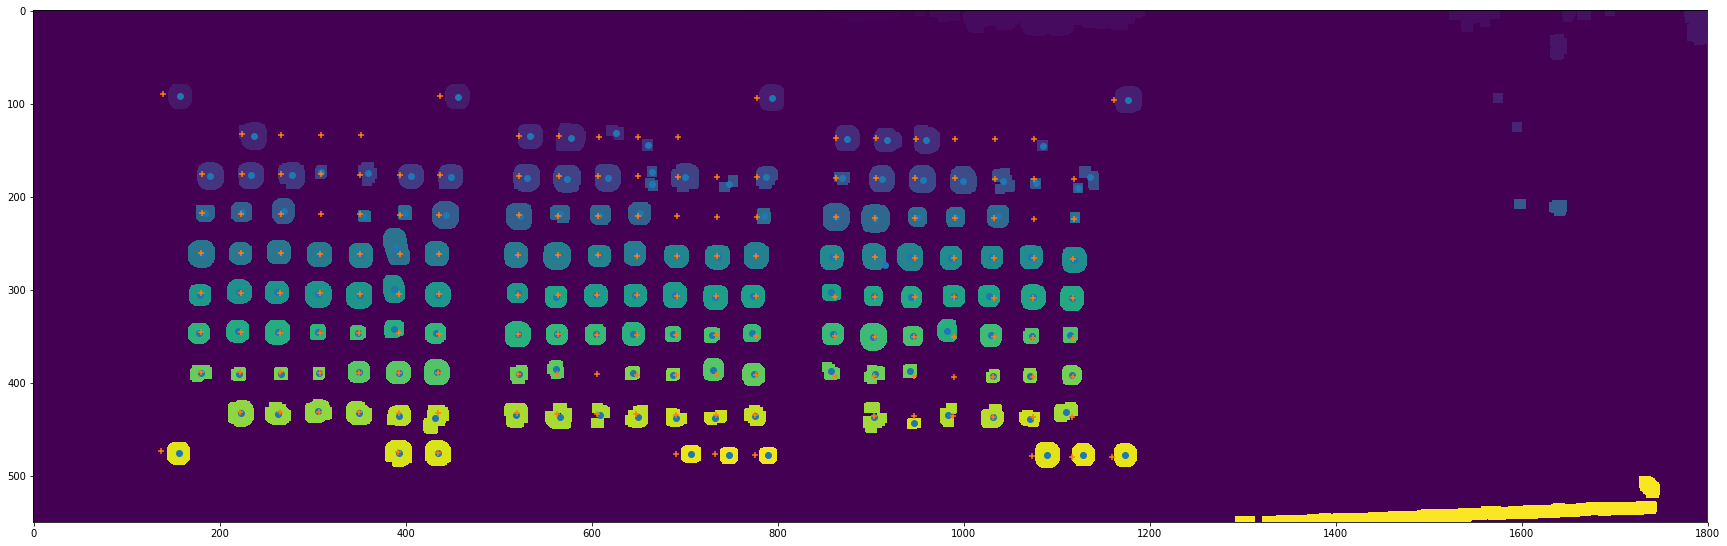

In [26]:
pitch, center_x, center_y, gridshape = estimate_grid(points_new,Peptides)
best_arg=minimize(err_func, x0=(pitch, center_x, center_y, 0), args=(points_new[:,0],points_new[:,1],gridshape))
X,Y=get_grid(gridshape,pitch=best_arg.x[0],center_x=best_arg.x[1],center_y=best_arg.x[2],rotation=best_arg.x[3])
pts=np.vstack([X,Y]).reshape(2,-1).T


print(finite.nonzero())
#draw the grid on image
fig, ax = plt.subplots(figsize=(30,10))

plt.scatter(points_new[:,1],points_new[:,0])
plt.scatter(pts[finite.nonzero(),1],pts[finite.nonzero(),0],marker="+")
plt.imshow(markers)
plt.show()




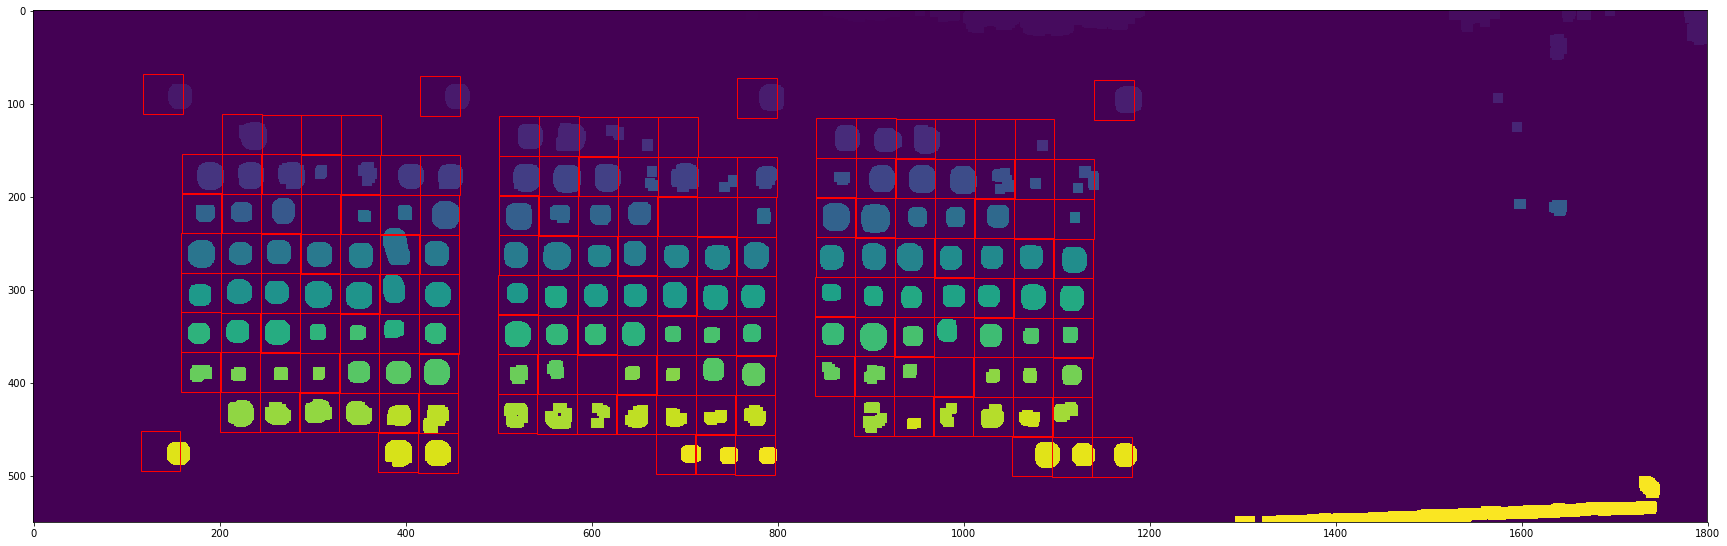

In [27]:
fig2 = plt.figure(figsize=(30,10))
ax2 = fig2.add_subplot(111, aspect='equal')

for p in [
    patches.Rectangle(
        (patchcenter[1]-0.5*pitch, patchcenter[0]-0.5*pitch),
        pitch,
        pitch,
        fill=False,      # remove background
        linewidth=1,
        edgecolor='r'
    ) for patchcenter in pts[finite.nonzero()]
]:
    ax2.add_patch(p)
plt.imshow(markers)
plt.show()

/home/janekg89/Envs/flutype-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/janekg89/Envs/flutype-analysis/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


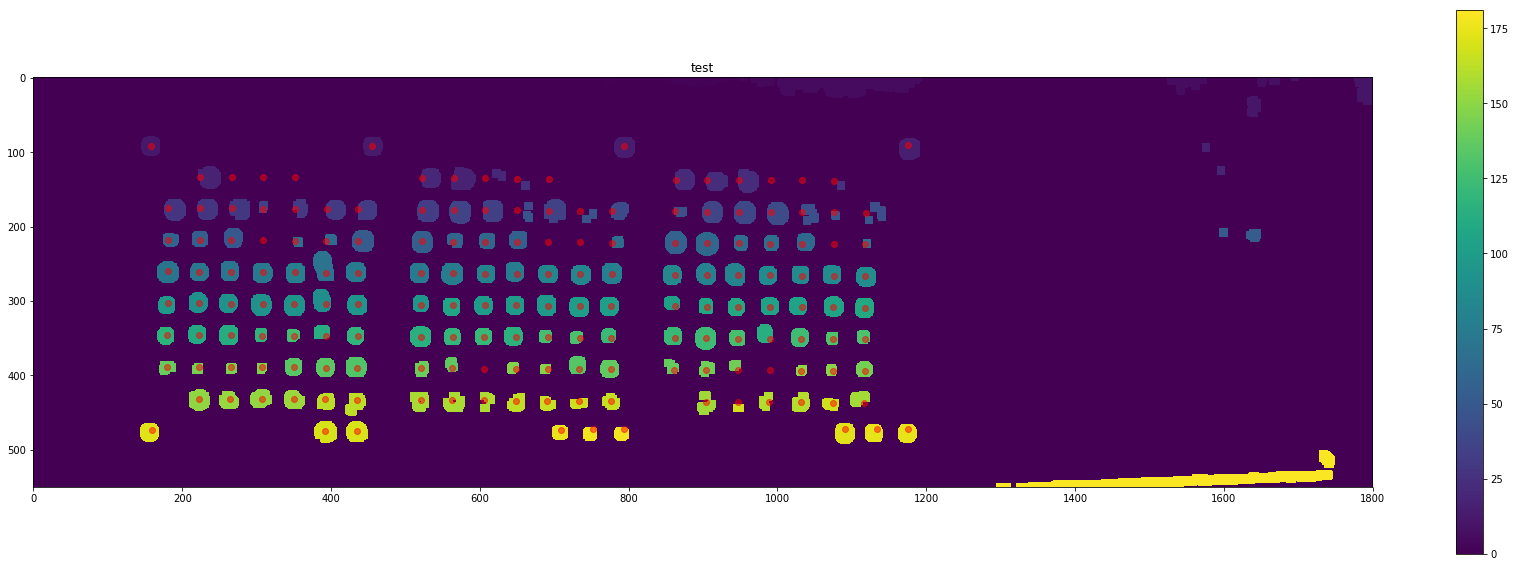

In [28]:


#display(Peptides)

#draw_grid(markers, Peptides[finite][~nonzero_ids]["y"],Peptides[finite][~nonzero_ids]["x"],"test")

Peptides["x"].iloc[Peptides[~leuchtefix.values][finite].index] =pts[Peptides[~leuchtefix.values][finite].index][:,0]
Peptides["y"].iloc[Peptides[~leuchtefix.values][finite].index]=pts[Peptides[~leuchtefix.values][finite].index][:,1]

#draw_grid(markers, Peptides[finite][~nonzero_ids]["y"],Peptides[finite][~nonzero_ids]["x"],"test")
draw_grid(markers, Peptides["y"],Peptides["x"],"test")




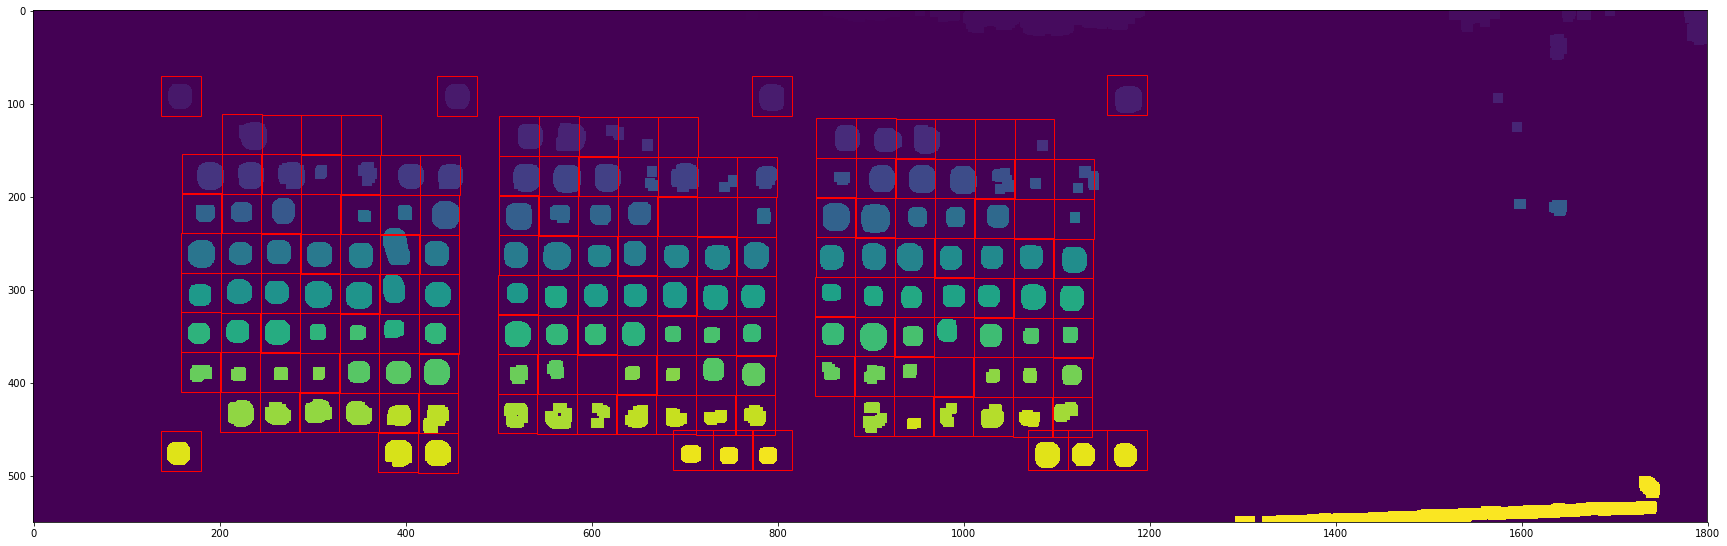

In [29]:
fig2 = plt.figure(figsize=(30,10))
ax2 = fig2.add_subplot(111, aspect='equal')

for p in [
    patches.Rectangle(
        (patchcenter_y-0.5*pitch, patchcenter_x-0.5*pitch),
        pitch,
        pitch,
        fill=False,      # remove background
        linewidth=1,
        edgecolor='r'
    ) for patchcenter_x, patchcenter_y in zip(Peptides[finite]["x"],Peptides[finite]["y"] )]:
    ax2.add_patch(p)
plt.imshow(markers)
plt.show()

## change grid position by hand to match image after incubation:

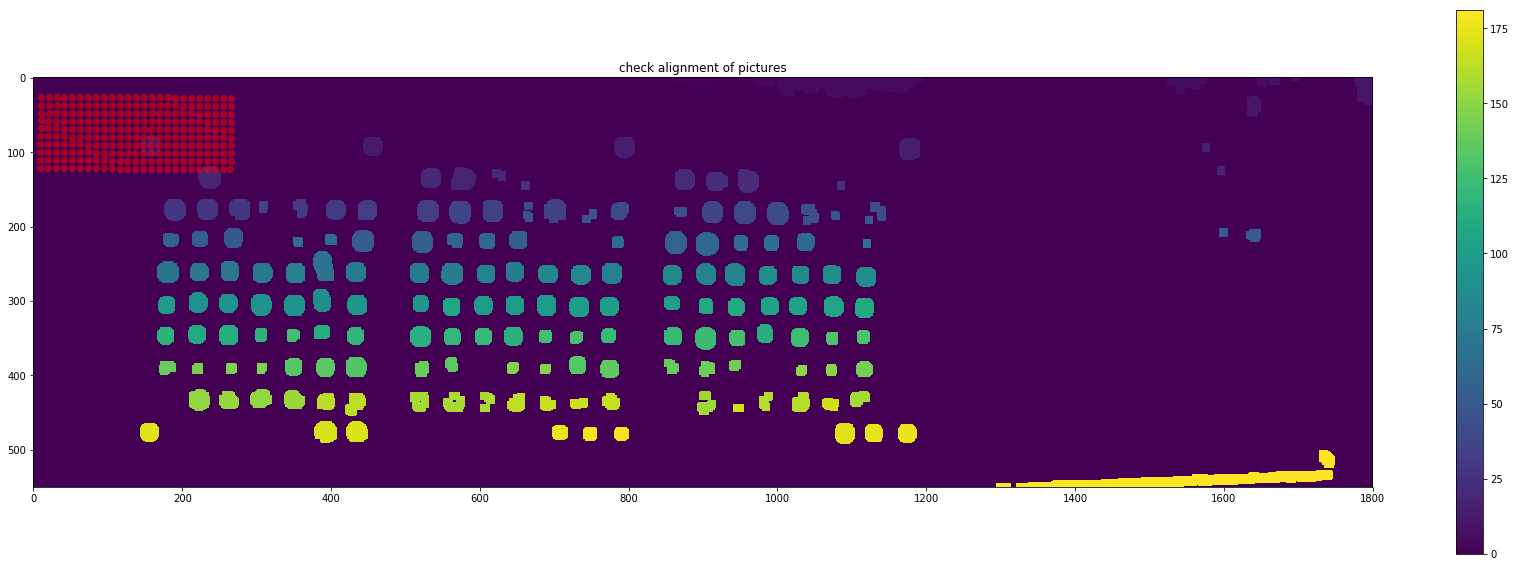

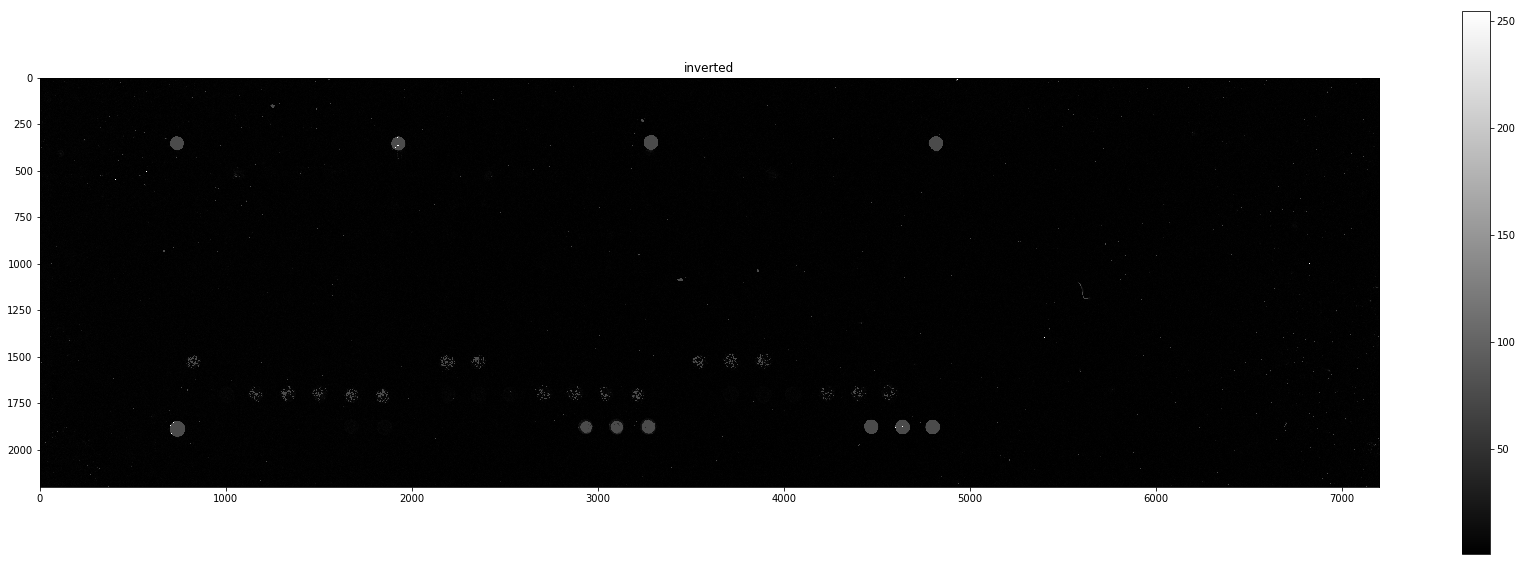

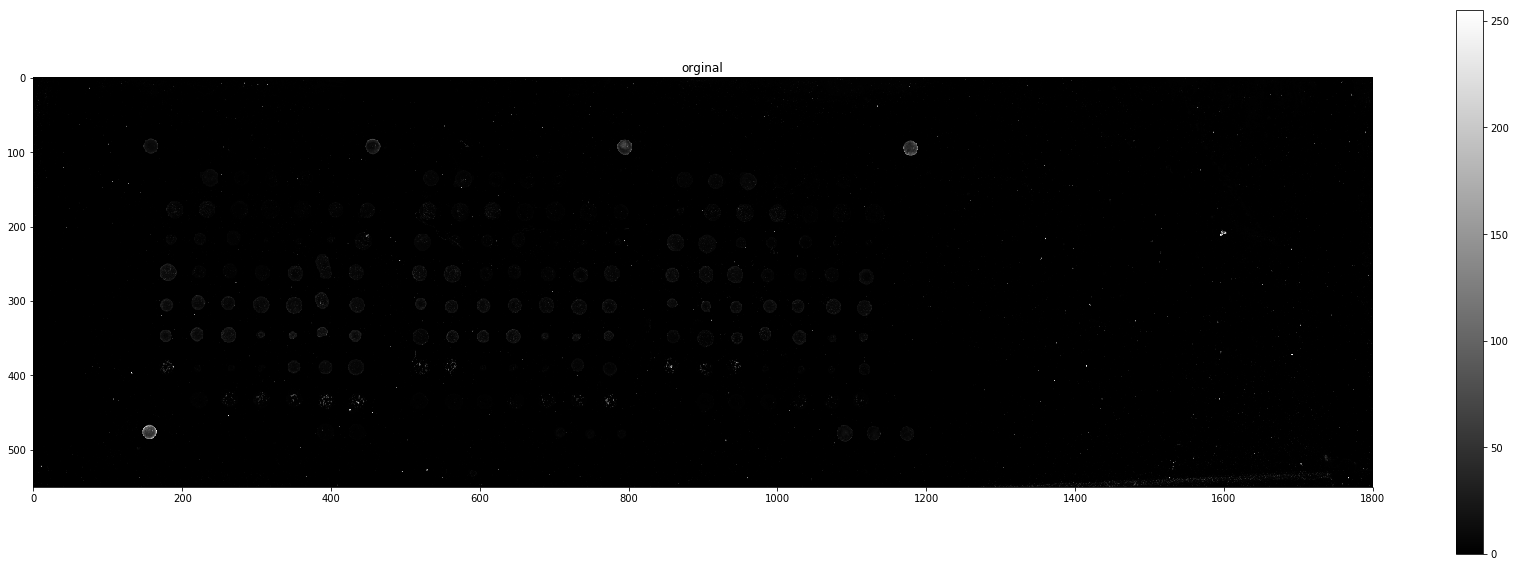

Row                 1           2           3            4           5   \
Column                                                                    
1       Leuchtefix 1.0       blank       blank        blank       blank   
2                blank       blank   Nenad 1.0  Fetuin 0.25  Fetuin 0.5   
3                blank  Kloe A 1.0  Kloe A 0.5  Kloe S 0.25  Kloe S 0.5   
4                blank   Pep7 0.25    Pep7 0.5     Pep7 1.0   Pep6 0.25   
5                blank   Pep10 1.0   Pep9 0.25     Pep9 0.5    Pep9 1.0   
6                blank   Pep12 0.5   Pep12 1.0   Pep11 0.25   Pep11 0.5   
7                blank  Pep14 0.25   Pep14 0.5    Pep14 1.0  Pep13 0.25   
8                blank      AK 1.0      Puffer       Puffer      Puffer   
9                blank       blank     AK 0.25       AK 0.5      AK 0.5   
10      Leuchtefix 1.0       blank       blank        blank       blank   

Row             6           7               8      9            10  \
Column                                                               
1            blank       blank  Leuchtefix 1.0  blank        blank   
2       Fetuin 1.0       blank           blank  blank    Nenad 0.5   
3       Kloe S 1.0  Nenad 0.25       Nenad 0.5  blank  Kloe A 0.25   
4         Pep6 0.5    Pep6 1.0     Kloe A 0.25  blank     Pep8 1.0   
5        Pep8 0.25    Pep8 0.5        Pep8 1.0  blank    Pep10 0.5   
6        Pep11 1.0  Pep10 0.25       Pep10 0.5  blank   Pep12 0.25   
7        Pep13 0.5   Pep13 1.0      Pep12 0.25  blank    Pep16 1.0   
8       Pep16 0.25   Pep16 0.5       Pep16 1.0  blank       AK 1.0   
9           AK 0.5      AK 1.0          AK 1.0  blank      AK 0.25   
10           blank     AK 0.25         AK 0.25  blank        blank   

Row          ...                     16     17          18           19  \
Column       ...                                                          
1            ...         Leuchtefix 1.0  blank       blank        blank   
2            ...                  blank  blank  Nenad 0.25    Nenad 0.5   
3            ...             Nenad 0.25  blank    Pep6 1.0  Kloe A 0.25   
4            ...               Pep6 1.0  blank    Pep8 0.5     Pep8 1.0   
5            ...               Pep8 0.5  blank  Pep10 0.25    Pep10 0.5   
6            ...             Pep10 0.25  blank   Pep13 1.0   Pep12 0.25   
7            ...              Pep13 1.0  blank   Pep16 0.5    Pep16 1.0   
8            ...              Pep16 0.5  blank      AK 1.0       AK 1.0   
9            ...                 AK 1.0  blank       blank      AK 0.25   
10           ...        Leuchtefix 0.25  blank       blank        blank   

Row             20           21           22              23              24  \
Column                                                                         
1            blank        blank        blank           blank           blank   
2        Nenad 1.0  Fetuin 0.25   Fetuin 0.5      Fetuin 1.0           blank   
3       Kloe A 0.5   Kloe A 1.0  Kloe S 0.25      Kloe S 0.5      Kloe S 1.0   
4        Pep7 0.25     Pep7 0.5     Pep7 1.0       Pep6 0.25        Pep6 0.5   
5        Pep10 1.0    Pep9 0.25     Pep9 0.5        Pep9 1.0       Pep8 0.25   
6        Pep12 0.5    Pep12 1.0   Pep11 0.25       Pep11 0.5       Pep11 1.0   
7       Pep14 0.25    Pep14 0.5    Pep14 1.0      Pep13 0.25       Pep13 0.5   
8           AK 1.0       Puffer       Puffer          Puffer      Pep16 0.25   
9          AK 0.25      AK 0.25       AK 0.5          AK 0.5          AK 0.5   
10           blank        blank        blank  Leuchtefix 0.5  Leuchtefix 0.5   

Row                 25  
Column                  
1       Leuchtefix 1.0  
2                blank  
3                blank  
4                blank  
5                blank  
6                blank  
7                blank  
8                blank  
9                blank  
10      Leuchtefix 0.5  

[10 rows x 25 columns]

'small'

In [30]:


if ratio[0] == ratio[1]:
    #scale position of spots:
    circles_new = circles/ratio[0]
    #changes position of spots
    circles_new[0,:,1] = circles_new[0,:,1]-25
    circles_new[0,:,0] = circles_new[0,:,0]+3
    
    Y_after=  Y/ratio[0]-25

    draw_grid(markers,Y/ratio[0]-25,X/ratio[0]+3,"check alignment of pictures")
    draw_imag(im.T,"inverted", cmap="gray")
    draw_imag(imafter.T,"orginal", cmap="gray")
    

    display(pep_cor.T,"small")
else:
    print("sizes of images before incubation and after incubation do not match (not possible to scale x and y axis with same factor" )


# Problems:
- different resolutions for different images.(todo: standard protokol peptide arrays, same resolution, same gain, same oriantation)
- different intensities before and after washing.
- not a regular grid (spotter? solution maybe : industial


# Questions:
- what is the spotting order?
- AK klumpt und fluoreszenz istvorhanden (bevor virus). Ist Antikörper schon mit Virus verschmutz?
- Wie AK an Mikroarray befestigt?

In [31]:
display(Peptides)

Peptides  Column  Row           x            y
0     Leuchtefix 1.0       1    1   91.875001   158.375000
1              blank       1    2         NaN          NaN
2              blank       1    3         NaN          NaN
3              blank       1    4         NaN          NaN
4              blank       1    5         NaN          NaN
5              blank       1    6         NaN          NaN
6              blank       1    7         NaN          NaN
7     Leuchtefix 1.0       1    8   91.626092   454.980512
8              blank       1    9         NaN          NaN
9              blank       1   10         NaN          NaN
10             blank       1   11         NaN          NaN
11             blank       1   12         NaN          NaN
12             blank       1   13         NaN          NaN
13             blank       1   14         NaN          NaN
14             blank       1   15         NaN          NaN
15    Leuchtefix 1.0       1   16   91.341625   793.958238
16             blank       1   17         NaN          NaN
17             blank       1   18         NaN          NaN
18             blank       1   19         NaN          NaN
19             blank       1   20         NaN          NaN
20             blank       1   21         NaN          NaN
21             blank       1   22         NaN          NaN
22             blank       1   23         NaN          NaN
23             blank       1   24         NaN          NaN
24    Leuchtefix 1.0       1   25   91.021599  1175.308181
25             blank       2    1         NaN          NaN
26             blank       2    2         NaN          NaN
27         Nenad 1.0       2    3  132.812552   223.969208
28       Fetuin 0.25       2    4  133.086249   266.582800
29        Fetuin 0.5       2    5  133.359946   309.196392
..               ...     ...  ...         ...          ...
220          AK 0.25       9   21  436.046551   989.098026
221           AK 0.5       9   22  436.320248  1031.711618
222           AK 0.5       9   23  436.593945  1074.325210
223           AK 0.5       9   24  436.867642  1116.938802
224            blank       9   25         NaN          NaN
225   Leuchtefix 1.0      10    1  473.225213   158.695026
226            blank      10    2         NaN          NaN
227            blank      10    3         NaN          NaN
228            blank      10    4         NaN          NaN
229            blank      10    5         NaN          NaN
230            blank      10    6         NaN          NaN
231          AK 0.25      10    7  474.830140   392.234044
232          AK 0.25      10    8  475.103837   434.847636
233            blank      10    9         NaN          NaN
234            blank      10   10         NaN          NaN
235            blank      10   11         NaN          NaN
236            blank      10   12         NaN          NaN
237            blank      10   13         NaN          NaN
238  Leuchtefix 0.25      10   14  472.762953   709.533832
239  Leuchtefix 0.25      10   15  472.727395   751.906048
240  Leuchtefix 0.25      10   16  472.691836   794.278264
241            blank      10   17         NaN          NaN
242            blank      10   18         NaN          NaN
243            blank      10   19         NaN          NaN
244            blank      10   20         NaN          NaN
245            blank      10   21         NaN          NaN
246            blank      10   22         NaN          NaN
247   Leuchtefix 0.5      10   23  472.442928  1090.883775
248   Leuchtefix 0.5      10   24  472.407369  1133.255991
249   Leuchtefix 0.5      10   25  472.371811  1175.628207

[250 rows x 5 columns]

## calculate spot intensities


In [32]:
Peptides["Intensity"]=0

for index in Peptides.index:

    if not math.isnan(Peptides.loc[index]['x']):
        x_min = int(Peptides.loc[index]['x']-0.5*pitch)
        x_max = int(Peptides.loc[index]['x']+0.5*pitch)
        y_min = int(Peptides.loc[index]['y']-0.5*pitch)
        y_max = int(Peptides.loc[index]['y']+0.5*pitch)
        intensity=imafter[y_min:y_max,x_min:x_max].sum()
        Peptides.set_value(index,"Intensity",intensity)
        
   

    

## generate csv file as readeroutput for intensity analysis

In [33]:
output=Peptides.pivot(index="Row", columns="Column", values="Intensity")
output.to_csv('data/{}.csv'.format(data_id), sep='\t')